For now we will use MLB's linear weights for each batted ball outcome

In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns

In [256]:
Weights = {"Walk": .695, "HitByPitch": .727,
           "Single": .891, "Double": 1.269,
            "Triple": 1.609, "HomeRun": 2.078}

In [257]:
Directory = "/Users/noahlippman/Documents/kclData"
csv_files = glob.glob(os.path.join(Directory, "*.csv"))
data = pd.read_csv(csv_files[0])

for f in csv_files[1:]:
    newGame =  pd.read_csv(f)
    data = pd.concat([data,newGame], axis = 0)
data = data[data['PlayResult'].notna()]

In [258]:
data['RunValue'] = data['PlayResult'].map(Weights)
data['RunValue'] = data['RunValue'].fillna(0)

In [259]:
Contact_Data = data[(data['PitchCall'] == "InPlay") & (data['ExitSpeed'].notna()) & (data['Angle'].notna())]
len(Contact_Data)
Contact_Data.head()

PitchNo       Date        Time  PAofInning  PitchofPA       Pitcher  \
2         3  5/30/2025  7:49:52 PM         1.0        3.0   Cayden Rose   
3         4  5/30/2025  7:50:23 PM         2.0        1.0   Cayden Rose   
10       11  5/30/2025  7:53:03 PM         5.0        1.0   Cayden Rose   
15       16  5/30/2025  7:54:56 PM         6.0        1.0   Cayden Rose   
18       19  5/30/2025  7:57:37 PM         6.0        2.0  Noah Suttles   

    PitcherId PitcherThrows            PitcherTeam               Batter  ...  \
2         NaN          Left      Kcl bluecaps 2025             Kam Ross  ...   
3         NaN          Left      Kcl bluecaps 2025      Brandon Schultz  ...   
10        NaN          Left      Kcl bluecaps 2025  Sammy Descarpentrie  ...   
15        NaN          Left      Kcl bluecaps 2025          Ty Cribbett  ...   
18        NaN         Right  Kcl groundsloths 2025        Riley Hendren  ...   

    yt_ReleaseDistance          Catcher CatcherId            CatcherTeam  \
2            54.667002     Nolan Hunter       NaN      Kcl bluecaps 2025   
3            54.667002     Nolan Hunter       NaN      Kcl bluecaps 2025   
10           54.667002     Nolan Hunter       NaN      Kcl bluecaps 2025   
15           54.667002     Nolan Hunter       NaN      Kcl bluecaps 2025   
18           54.667002  Drew Wichtowski       NaN  Kcl groundsloths 2025   

    yt_AeroModel     PlayMadeBy  Position  ShortThrow     RunValue  
2        2022-11  Riley Hendren       8.0         NaN NaN    0.000  
3        2022-11            NaN       NaN         NaN NaN    0.891  
10       2022-11            NaN       NaN         NaN NaN    0.891  
15       2022-11  Riley Hendren       8.0         NaN NaN    0.000  
18       2022-11       Kam Ross       8.0         NaN NaN    0.000  

[5 rows x 130 columns]

In [260]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor

X = Contact_Data[['ExitSpeed', 'Angle']]
Y = Contact_Data['RunValue'] 

def CV():
    k_scores = {}
    for i in range(1,20):
        xwoba_model = KNeighborsRegressor(n_neighbors = i)
        k_folds = KFold(n_splits = 5)
        scores = cross_val_score(xwoba_model, X, Y, cv = k_folds, scoring = 'neg_root_mean_squared_error') * -1
        k_scores[i] = scores.mean()
    return k_scores

scores = CV()

Text(0, 0.5, 'RMSE')

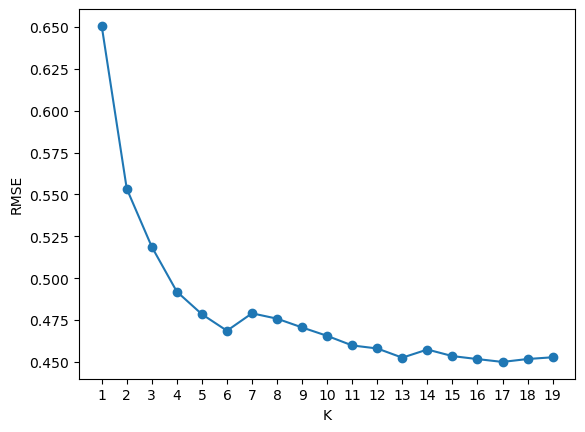

In [261]:
K_vals = scores.keys()
RMSE_vals = scores.values()
plt.scatter(K_vals,RMSE_vals)
plt.plot(K_vals,RMSE_vals)
plt.xticks([i for i in range(1,20)])
plt.xlabel("K")
plt.ylabel("RMSE")

In [262]:
xwoba_model = KNeighborsRegressor(n_neighbors = 6)
xwoba_model.fit(X,Y)

KNeighborsRegressor(n_neighbors=6)

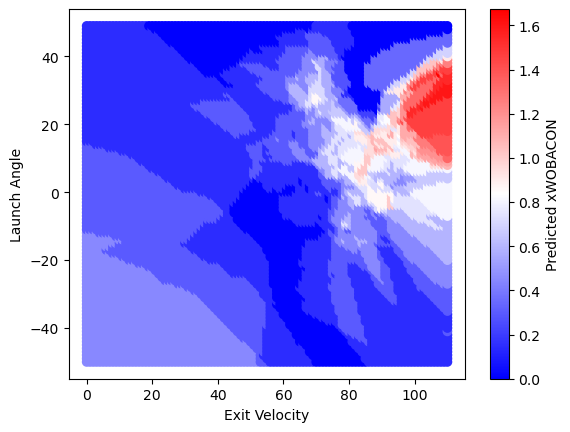

1.6734999999999998

In [263]:
from itertools import product

exit_speeds = range(0,111)
launch_angles = range(-50,50)
combinations = list(product(exit_speeds, launch_angles))

sim_data = pd.DataFrame(combinations, columns = ['ExitSpeed', 'Angle'])
sim_data['predictedRunValue'] = xwoba_model.predict(sim_data)

X_sim = sim_data['ExitSpeed']
Y_sim = sim_data['Angle']
Z_sim = sim_data['predictedRunValue']

plt.scatter(X_sim,Y_sim,c = Z_sim, cmap = 'bwr')
plt.xlabel("Exit Velocity")
plt.ylabel("Launch Angle")
plt.colorbar(label = "Predicted xWOBACON")
plt.show()
max(Z_sim)

Lets now calculate each individual player's xWOBA

In [264]:
hitters = data['Batter'].unique()
hitterDict = {}

for hitter in hitters:
    hitter_data = data[data['Batter'] == hitter]
    try:
        contact_data = Contact_Data[(Contact_Data['PitchCall'] == "InPlay") & (Contact_Data['Batter'] == hitter)]
        non_con_data = hitter_data[hitter_data['PitchCall'] != "InPlay"]
        xWOBACON = (xwoba_model.predict(contact_data[['ExitSpeed', 'Angle']])).sum()
        xWOBA = (xWOBACON + non_con_data['RunValue'].sum()) / len(hitter_data)
        hitterDict[hitter] = round(xWOBA,3)
    except:
        non_con_data = hitter_data[hitter_data['PitchCall'] != "InPlay"]
        xWOBA = (non_con_data['RunValue'].sum()) / len(hitter_data)
        hitterDict[hitter] = round(xWOBA,3)

hitters_data = pd.DataFrame(hitters, columns = ['Batter'])
hitters_data['xWOBA'] = hitters_data['Batter'].map(hitterDict)

hitters_data = hitters_data.sort_values(by = 'xWOBA', ascending = False)
hitters_data['Rank'] = range(len(hitters_data['Batter']))
hitters_data['Percentile'] = (len(hitters_data['xWOBA']) - hitters_data['Rank'])/len(hitters_data) *100
hitters_data.drop("Rank", inplace = True, axis = 1)
hitters_data

Batter  xWOBA  Percentile
32       Kaileb Hackman  0.614  100.000000
26          Logan Lynch  0.572   98.305085
21         Tyler Pippin  0.530   96.610169
58       Jake Zimmerman  0.516   94.915254
22         Lawson Alwan  0.509   93.220339
41       Cody Delfavero  0.465   91.525424
47          Ryan Theile  0.463   89.830508
12           Will Vogel  0.440   88.135593
23       Lawson Shickel  0.425   86.440678
20       Braxton Waller  0.399   84.745763
29     Teagan Disharoom  0.377   83.050847
3   Sammy Descarpentrie  0.377   81.355932
30   Cameron Steinbaugh  0.376   79.661017
38          Zach Spidle  0.371   77.966102
40         Jake Morrill  0.364   76.271186
43          Will Strehl  0.327   74.576271
0              Kam Ross  0.322   72.881356
15        Michael Lucas  0.320   71.186441
28           Brady Hart  0.314   69.491525
57       Thomas Mickels  0.310   67.796610
13    Grayson Schnierle  0.305   66.101695
24         Gavin Kleist  0.300   64.406780
50        Jaxson Grubbs  0.300   62.711864
44           Zayn Giles  0.297   61.016949
55        Deegan Aeilts  0.291   59.322034
2       Bennett Summers  0.276   57.627119
25       Taylor Vorhees  0.264   55.932203
37       Brady Veselack  0.262   54.237288
5         Riley Hendren  0.261   52.542373
46           Kyler Lapp  0.260   50.847458
9       Drew Wichtowski  0.260   49.152542
33         Nick Guidici  0.250   47.457627
18         Nolan Hunter  0.249   45.762712
45          Cal Darling  0.236   44.067797
51       Josh Eisfelder  0.232   42.372881
16           Owen Laroe  0.220   40.677966
39          Jake Folmar  0.210   38.983051
1       Brandon Schultz  0.198   37.288136
53          Gabe Peters  0.198   35.593220
35     Cameron Anderson  0.194   33.898305
7       Trey Blanchette  0.184   32.203390
14       Trey Schilling  0.180   30.508475
36           Colin Karr  0.178   28.813559
42       Justin Trusner  0.174   27.118644
6         Ethan Hamrick  0.169   25.423729
31        Clint Goodman  0.124   23.728814
49        Brooks Neuhof  0.119   22.033898
4           Ty Cribbett  0.106   20.338983
54       Nolan Vanduzer  0.081   18.644068
11          Adan Nieves  0.074   16.949153
27         Jacob Blunck  0.063   15.254237
34         Max Michalak  0.059   13.559322
48        Trey Thompson  0.000   11.864407
10       Kaden Griswold  0.000   10.169492
8         Jacob Trusner  0.000    8.474576
52       Brayden  Windy  0.000    6.779661
19         Nolan Bowles  0.000    5.084746
17            Kam  Ross  0.000    3.389831
56          Braden Mehn  0.000    1.694915

In [265]:
hitters_data.to_csv('/Users/noahlippman/Documents/Kernelytics/xWOBA_Data.csv')